In [1]:
'''
Import the modules that will be used
'''

import sys
import warnings
from distutils.version import LooseVersion

import numpy as np
import tensorflow as tf
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

import network
import utils

%matplotlib inline

In [2]:
'''
Define the neural network that was used and define hyper-parameters.
These are needed to infer from the saved network checkpoint
'''

tf.reset_default_graph()

cp_dir = '/home/cjw/disk2cjw/PythonLib/cjwdeeplearning/autoencoder/checkpoint-2018-03-19-11-19-18/'
#checkpoint-2018-03-02-16-31-42/'
width = 64
height = 64
nchannels = 1
channels = [0]
batchsize = 32
learning_rate = 0.00005

latent_size = 128
enc_sizes = [(64, 5), (128, 3), (256,3), (512,3)] #, (64, 3), (128,3)] #, (32, 3), (64, 3)]
dec_sizes = list(reversed(enc_sizes))
# enc_sizes = [(64, 5), (128, 3), (256,3), (512,3)]
# dec_sizes = list(reversed(enc_sizes))

images = tf.placeholder(tf.float32, (None, height, width, nchannels))
z = tf.placeholder(tf.float32, (None, latent_size))

enc = network.encoder(images, latent_size, droprate=.7, is_train=False,
                      nfilters=enc_sizes)
sdd = network.decoder(enc, nchannels=nchannels, width=width, droprate=.7,
                      is_train=False, nfilters=dec_sizes)

loss = network.ae_loss(images, sdd, nchannels=nchannels,
                       latent_size=latent_size, width=width)

opt = network.model_opt(loss, learning_rate)

saver = tf.train.Saver()

sess = tf.Session()
sess.run(tf.global_variables_initializer())
saver = tf.train.import_meta_graph(cp_dir + 'autoencoder-128x-13980.meta') #autoencoder-64x-18660.meta')
saver.restore(sess, tf.train.latest_checkpoint(cp_dir + ''))


Encoder False
[<tf.Tensor 'Placeholder:0' shape=(?, 64, 64, 1) dtype=float32>, <tf.Tensor 'Maximum:0' shape=(?, 32, 32, 64) dtype=float32>, <tf.Tensor 'Maximum_1:0' shape=(?, 16, 16, 128) dtype=float32>, <tf.Tensor 'Maximum_2:0' shape=(?, 8, 8, 256) dtype=float32>, <tf.Tensor 'Maximum_3:0' shape=(?, 4, 4, 512) dtype=float32>] Tensor("latent_space/BiasAdd:0", shape=(?, 128), dtype=float32)
isize:  4 64
[<tf.Tensor 'Maximum_4:0' shape=(?, 8192) dtype=float32>, <tf.Tensor 'Reshape:0' shape=(?, 4, 4, 512) dtype=float32>, <tf.Tensor 'Maximum_5:0' shape=(?, 8, 8, 256) dtype=float32>, <tf.Tensor 'Maximum_6:0' shape=(?, 16, 16, 128) dtype=float32>, <tf.Tensor 'Maximum_7:0' shape=(?, 32, 32, 64) dtype=float32>] Tensor("decoder_out/BiasAdd:0", shape=(?, 64, 64, 1), dtype=float32)
INFO:tensorflow:Restoring parameters from /home/cjw/disk2cjw/PythonLib/cjwdeeplearning/autoencoder/checkpoint-2018-03-19-11-19-18/autoencoder-128x-13980


In [3]:
datadir = "/home/cjw/disk2cjw/Data/cyto/ChannelOne"
#datadir = "/home/cjw/disk2cjw/Data/yeast/"
mmfiles = utils.list_mmfiles(datadir)
print(mmfiles)

mmdict = dict()

n_all_images = 0
for mmfilename in mmfiles:
#mmfilename = datadir + "Fish6_15_cjw_mean_zero.mm"
#mmfilename = datadir + "mmplate15-1.mm"
    mmheader = np.memmap(mmfilename, dtype="int32", mode='r',
                    shape=(4,))

    header_shape = mmheader.shape
    print(header_shape, mmheader)
    xshape = [mmheader[0], mmheader[1], mmheader[2], mmheader[3]]
    xshape = tuple(xshape)
    del mmheader
    n_all_images += xshape[0]
    
    m3 = np.memmap(mmfilename, dtype='float32', offset=128,
              mode='r', shape=xshape)
    key = mmfilename.split("/")[-1]
    mmdict[key] = m3

print(n_all_images)
mmdict.keys()

['/home/cjw/disk2cjw/Data/cyto/ChannelOne/Fish6_CCB_16.tif.mm', '/home/cjw/disk2cjw/Data/cyto/ChannelOne/Fish6_15.tif.mm', '/home/cjw/disk2cjw/Data/cyto/ChannelOne/Fish6_ice_22.tif.mm']
(4,) [10000    64    64     1]
(4,) [10000    64    64     1]
(4,) [10000    64    64     1]
30000


dict_keys(['Fish6_CCB_16.tif.mm', 'Fish6_15.tif.mm', 'Fish6_ice_22.tif.mm'])

In [4]:
n = xshape[0]
all_ids =  range(n_all_images)
idx = 0
dataframes = list()
for key in mmdict.keys():
    mm = mmdict[key]
    n = mm.shape[0]
    print(n)
    file = n*[key[0:-3]]
    fid = range(n)
    mmfile = n*[key]
    plate = n*[0]
    row = n*[0]
    column = n*[0]
    field = n*[0]
    yc = n*[32]
    xc = n*[32]
    well = n*[0]
    ids = all_ids[idx:idx + n]
    idx += n
    xdf = pd.DataFrame({'id':ids, 'fid':fid, 'file':file, 'mmfile':mmfile, 'plate':plate,
                     'row':row, 'column':column, 'field':field,
                      'yc':yc, 'xc':xc, 'well':well})

    dataframes.append(xdf)
    
df = pd.concat(dataframes, ignore_index=True)

10000
10000
10000


In [5]:
sns.set_style("whitegrid", {'axes.grid' : False})

(30000, 128) (30000, 64, 64, 1)
-0.240300297737 1.32657456398


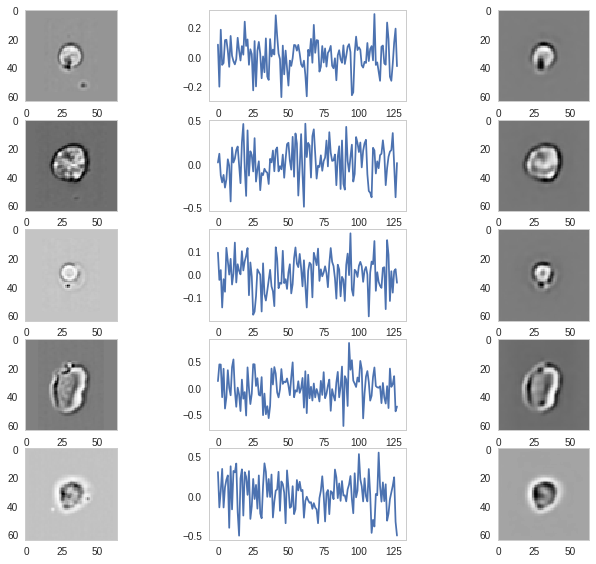

In [8]:
'''Read the images, display image, encode and show latent space, show decoded'''

vv = utils.getWell(mmdict,
                    df, width, 0, 0, nchannels, channels=channels)

nvv = len(vv)
offloc = 0
offstep = 1000
offnext = offloc + offstep
xhe = np.zeros((nvv, latent_size))
xdd = np.zeros((nvv, width, height, nchannels))
while offloc < nvv:
    #print(offloc, offnext)
    xhe[offloc:offnext] = sess.run(enc, feed_dict={images:vv[offloc:offnext]})
    xdd[offloc:offnext] = sess.run(sdd, feed_dict={enc:xhe[offloc:offnext]})
    offloc = offnext
    offnext += offstep
    if offnext > nvv:
        offnext = nvv
        
f = plt.figure(figsize=(12, 40))
print(xhe.shape, xdd.shape)
print(np.amin(vv),np.amax(vv))
for i in range(5):
    ix = np.random.randint(0, len(vv))
    #print(ix)
    plt.subplot(20,3,i*3 + 1)
    plt.imshow(vv[ix,:,:,0])
    plt.subplot(20,3,i*3 + 2)
    plt.plot(xhe[ix])
    plt.subplot(20,3,i*3 + 3)
    plt.imshow(xdd[ix,:,:,0])
   

In [10]:
'''Encode the images with the trained network and store the latent spaces in an array'''

dv = {0:(0,0)}
dimages = dict()
counter = 0
one = 0
for k in dv.keys():
    i, j = dv[k]
    print(i, j)
    r = i + 1
    cm = j + 1
    try:
        k = vv #utils.getWell(mmdict,df, width, 0, 0, nchannels, channels=[0])
        print(len(k))
    except:
        print("Oh no!!")
        continue
    hek = xhe #sess.run(enc, feed_dict={images:k})
    print('hek', hek.shape)
    dimages[counter] = k
    if one == 0:
        one = 1
        g = hek
        colors = np.zeros(k.shape[0])
        counter += 1
        print(i, j, g.shape, hek.shape)
    else:
        print(i, j, g.shape, hek.shape)
        g = np.concatenate((g,hek))
        colors = np.concatenate((colors, counter + np.zeros(k.shape[0])))
        counter += 1

g_all = g
g_all.shape

0 0
30000
hek (30000, 128)
0 0 (30000, 128) (30000, 128)


(30000, 128)

In [11]:
''' Create some colors for display later on'''

from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
clist = [(.2,.2,.2),
         (172/255,25/255,210/255),
         (255/255, 165./255, 0),
         (44/255,25/255,210/255),
         (134/255, 165./255, 56/255),
         (26/255,188/255,255/255),
         (188/255,255/255, 26/255),
         (1, 0,0), (0,1,0), (0,0,1)]

mycmap = LinearSegmentedColormap.from_list(
        'mycmap', clist, N=len(clist))

bounds = np.linspace(0, len(clist), len(clist) + 1)
norm = mpl.colors.BoundaryNorm(bounds, mycmap.N)
print(bounds, mycmap.N)

[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.] 10


In [12]:
'''Do PCA on the latent space features'''

from sklearn.decomposition import PCA
pca = PCA(n_components=32, svd_solver='arpack', whiten=True, copy=True)
gfit = pca.fit_transform(g_all)
print(gfit.shape)
print(pca.explained_variance_)
print(pca.components_.shape)


(30000, 32)
[ 0.27704887  0.22620874  0.17614404  0.14656195  0.1264397   0.12170782
  0.11935053  0.10923748  0.10468115  0.09962468  0.09123282  0.08677579
  0.08620796  0.08348417  0.07902138  0.07690162  0.07348373  0.06949575
  0.06865294  0.06515938  0.06230905  0.06137015  0.05875562  0.05806727
  0.05723877  0.05459568  0.05250272  0.05203865  0.04956217  0.04753163
  0.04663294  0.04617244]
(32, 128)


In [13]:
'''
Do clustering on the latent space features
find eight cluster for K-Means and Allomerative Clustering
'''

nclust = 12
from sklearn import cluster

km = cluster.KMeans(n_clusters=nclust).fit_predict(g_all)
agc = cluster.AgglomerativeClustering(n_clusters=nclust, affinity='euclidean', linkage="ward").fit_predict(g_all)


###  Show results of clustering using K-Means

Each row is a cluster found using the K-Means algorithm. The images are randomly selected from each cluster.
The image in the first column of every row is decoded from the average of the latent space features for each cluster.

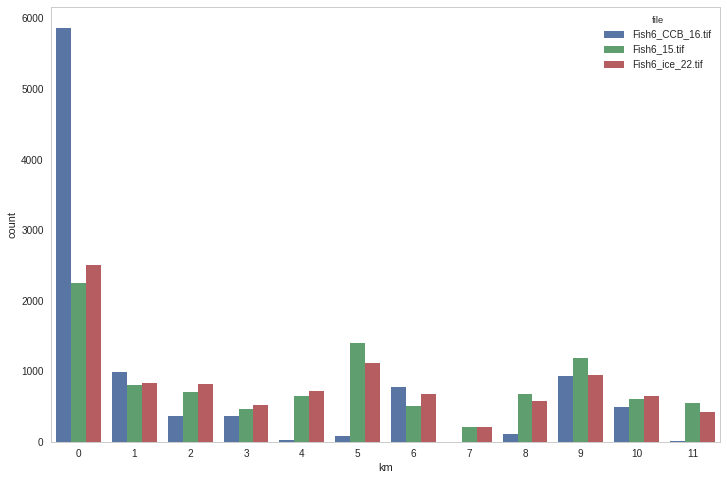

In [15]:
df['km'] = km

plt.figure(figsize=(12,8))
sns.set_style("whitegrid", {'axes.grid' : False})
sns.countplot(x='km', data=df, hue='file')

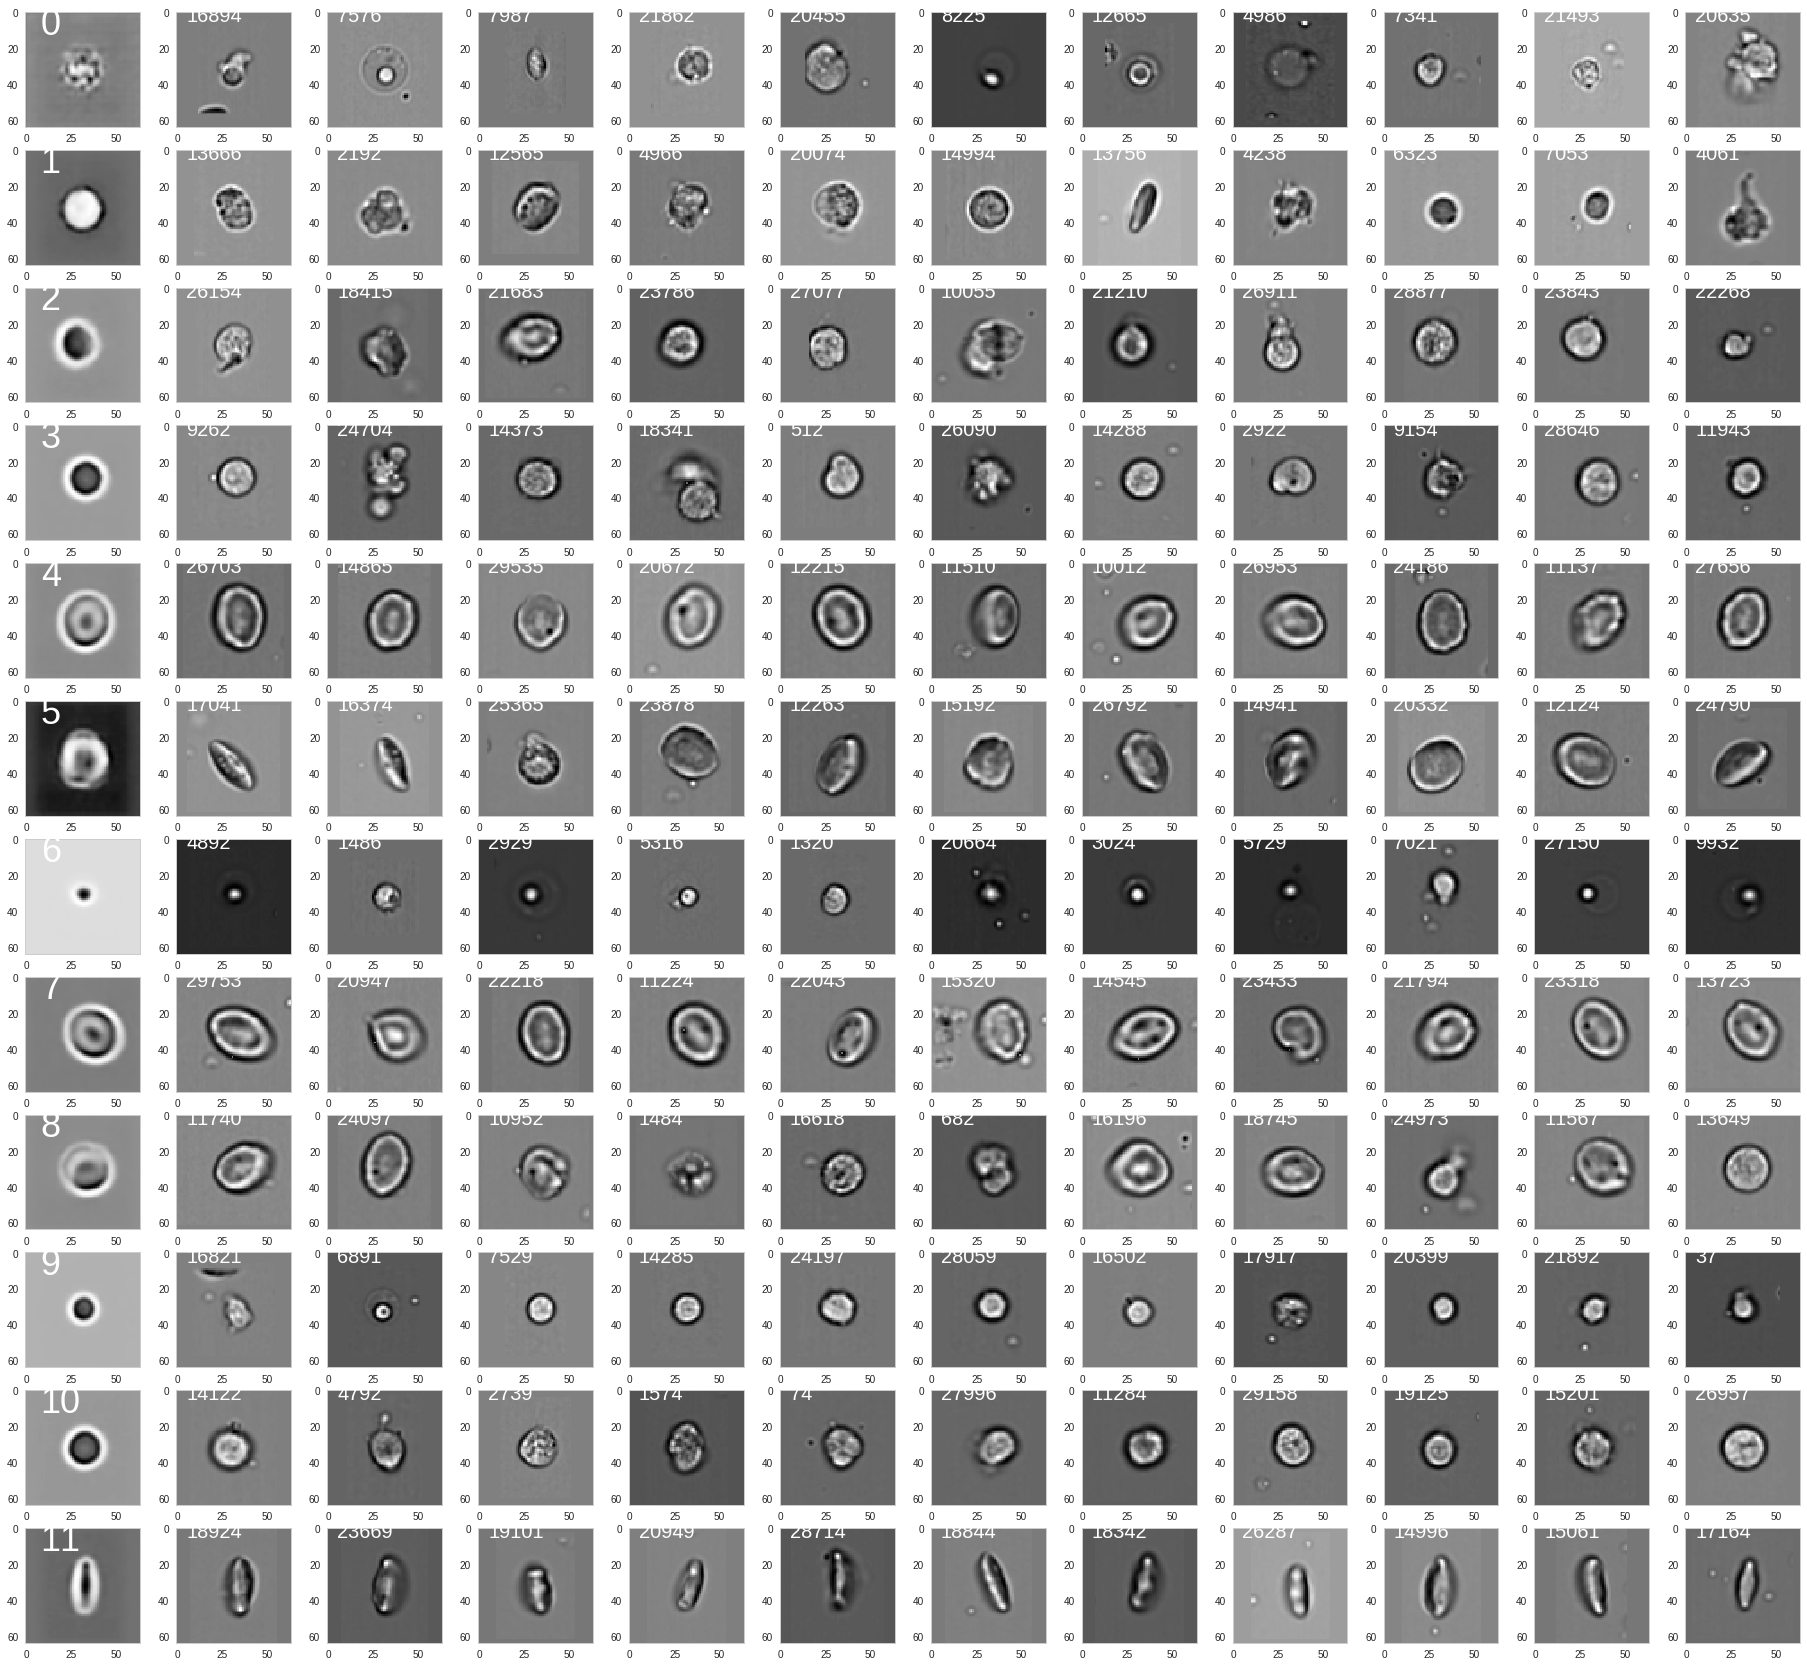

In [18]:
ximages = vv
ximages.shape

nk = nclust
plt.figure(figsize=(32, 2.5*nk))

counter = 1
shift = 0
for k in range(nk):
    #row = ximages[km == k]
    rowdf = df[df['km'] == k]
    inum = list(rowdf.index)
    
    gk = g_all[km == k]
    gavk = np.mean(gk, axis=0)
    gavk = np.expand_dims(gavk.squeeze(), axis=0)
    resav = sess.run(sdd, feed_dict={enc:gavk})
    plt.subplot(nk, 12, counter)
    plt.imshow(resav.squeeze())
    plt.text(8, 12,str(k), fontsize=36, color='white')
    counter += 1
    for i in range(11):
        plt.subplot(nk, 12, counter)
        counter += 1
        try:
            rnd = inum[np.random.randint(0,len(inum))]
            plt.imshow(ximages[rnd,:,:,0], cmap='gray')
            plt.text(5, 5,str(rnd), fontsize=20, color='white')
            #print(rnd, df.iloc[rnd]['mmfile'])
        except:
            plt.imshow(np.zeros((64,64)))

###  Show results of clustering using Agglomerative Clustering

Each row is a cluster found using the [Agglomerative Clustering](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.AgglomerativeClustering.html#sklearn.cluster.AgglomerativeClustering)
algorithm. The images are randomly selected from each cluster.
The image in the first column of every row is decoded from the average of the latent space features for each cluster.

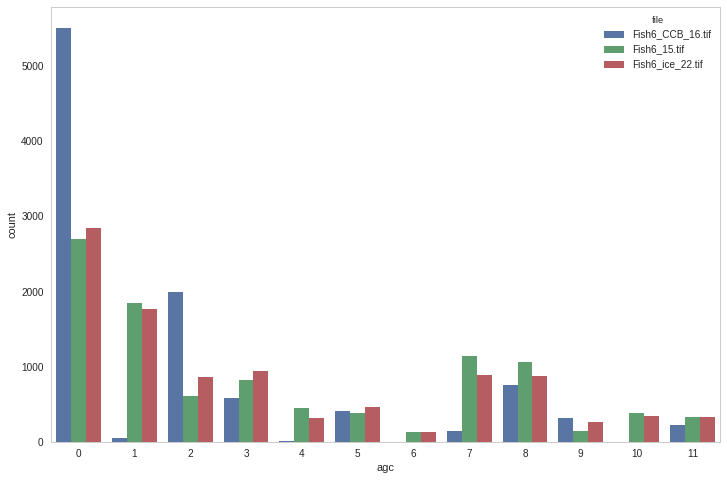

In [19]:
df['agc'] = agc
plt.figure(figsize=(12,8))
sns.countplot(x='agc', data=df, hue='file')

0 11048
1 3661
2 3455
3 2342
4 777
5 1254
6 260
7 2179
8 2691
9 721
10 727
11 885


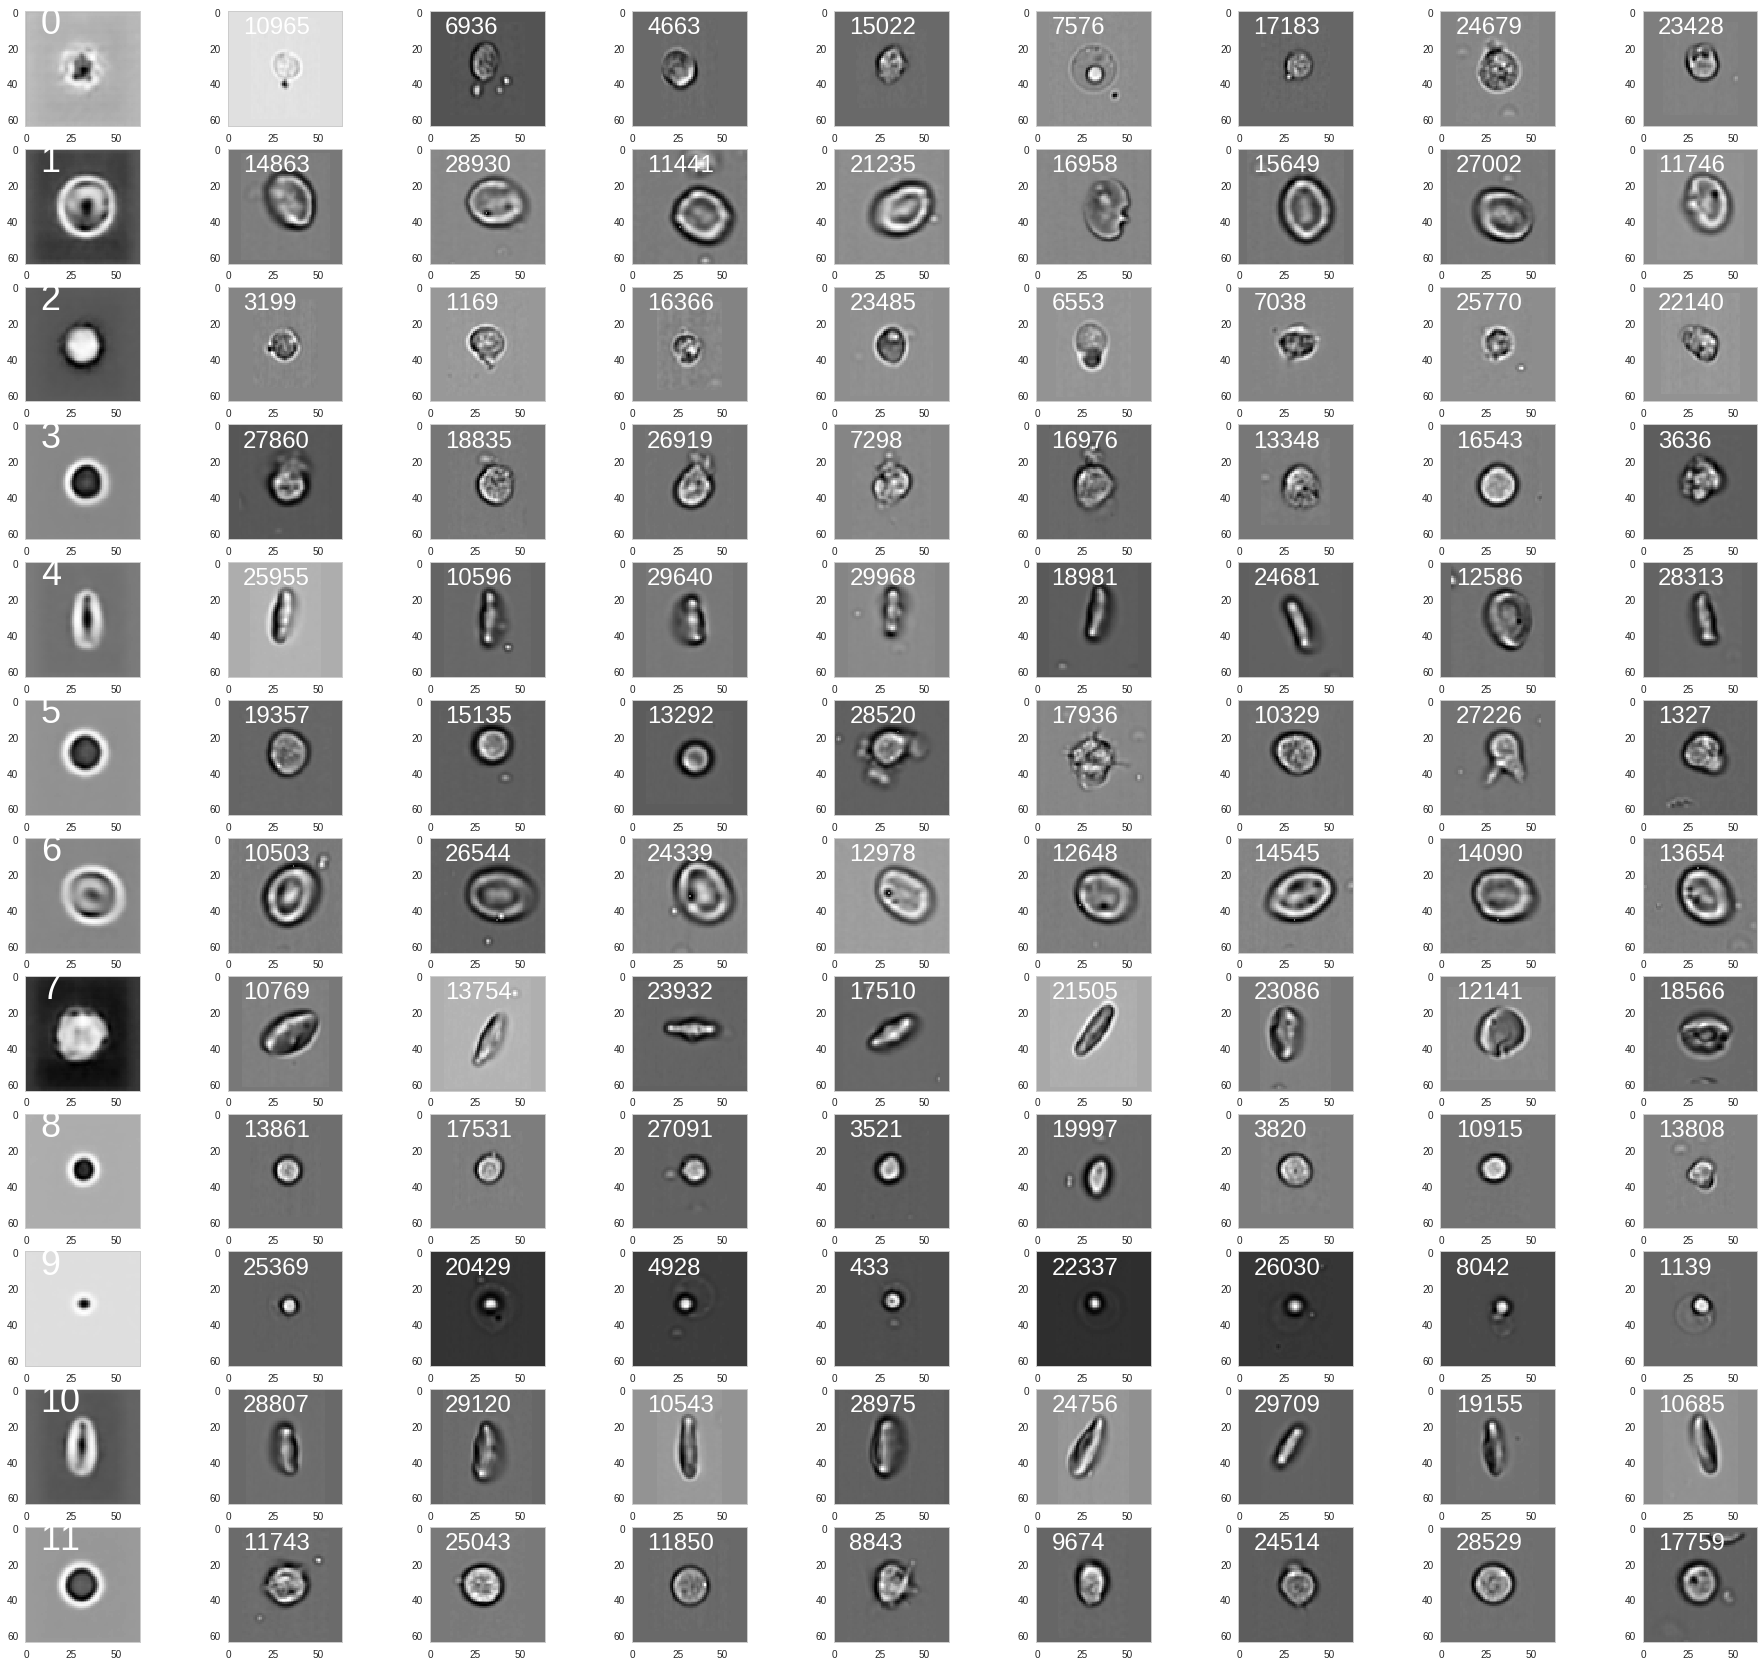

In [20]:
nk = nclust
plt.figure(figsize=(32, 2.5*nk))

counter = 1
shift = 0
for k in range(nk):
    #row = ximages[agc == k]
    rowdf = df[df['agc'] == k]
    inum = list(rowdf.index)
    print(k, len(rowdf))
    gk = g_all[agc == k]
    gavk = np.mean(gk, axis=0)
    gavk = np.expand_dims(gavk.squeeze(), axis=0)
    resav = sess.run(sdd, feed_dict={enc:gavk})
    plt.subplot(nk, 9, counter)
    plt.imshow(resav.squeeze())
    plt.text(8, 12,str(k), fontsize=36, color='white')
    counter += 1
    for i in range(8):
        plt.subplot(nk, 9, counter)
        counter += 1
        try:
            rnd = inum[np.random.randint(0,len(inum))]
            plt.imshow(ximages[rnd,:,:,0], cmap='gray')
            plt.text(8, 12,str(rnd), fontsize=24, color='white')
        except:
            plt.imshow(np.zeros((64,64)))

-------------------------------------------------------------------------

(260, 64, 64, 1)


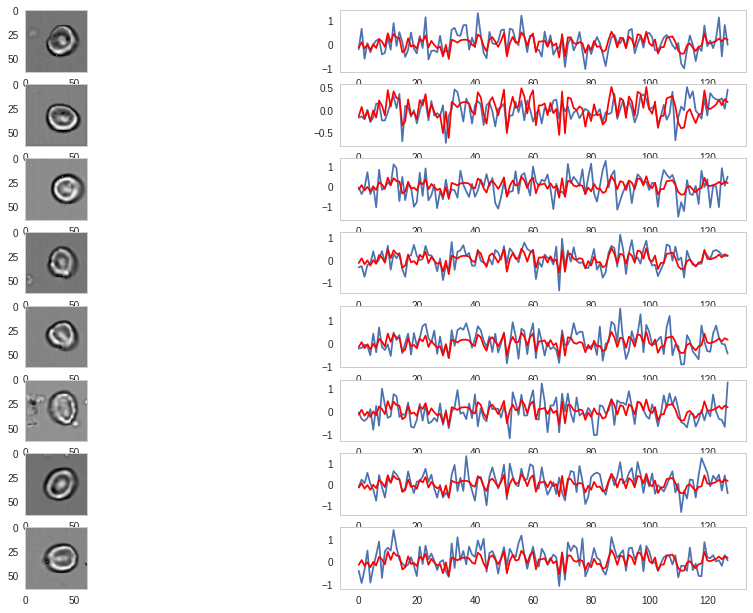

In [30]:
tn = 6
images4 = ximages[agc == tn]
g4 = g_all[agc == tn]
plt.figure(figsize=(16,12))
print(images4.shape)

gtest = np.mean(g4, axis=0)
gtest = np.expand_dims(gtest.squeeze(), axis=0)
res = sess.run(sdd, feed_dict={enc:gtest})

gav = np.mean(g_all, axis=0)
gav = np.expand_dims(gav.squeeze(), axis=0)
resav = sess.run(sdd, feed_dict={enc:gav})

ppi = 0
for i in range(8):
    ix = np.random.randint(0, len(g4))
    plt.subplot(9,2,i*2 + 1)
    plt.imshow(images4[ix,:,:,0], cmap='gray')
    plt.subplot(9,2, i*2 + 2)
    plt.plot(g4[ix,:])
    plt.plot(gtest.squeeze(), c='r')
    ppi += 2

#plt.subplot(9,2, ppi+ 1 )
#plt.imshow(res.squeeze())
#plt.subplot(9,2, ppi + 2)
#plt.plot(gtest.squeeze())
#plt.subplot(6,2, ppi + 3)
#plt.imshow(resav.squeeze())
#plt.subplot(6,2, ppi + 4)
#plt.plot(gav.squeeze())


In [78]:
from sklearn.manifold import TSNE

geez = list()
ceez = list()
cindex = 0
for i in (1,9,2,5):
    gna = g_all[agc == i]
    ca = cindex #np.array(clist[cindex])
    cna = np.repeat([i], gna.shape[0], axis=0)
    geez.append(gna)
    ceez.append(cna)
    cindex += 1
# c3 = gn3.shape[0]*(1, 0, 0)
# c6 = gn3.shape[0]*(0, 1, 0)
# c10 = gn3.shape[0]*(0, 0, 1)
gn = np.concatenate(geez)
cn = np.concatenate(ceez)
# cn = np.concatenate((c3, c6, c10))
print(gn.shape)
g_emb = TSNE(n_components=2,perplexity=50, learning_rate=1000).fit_transform(gn.astype(np.float64))
print(g_emb.shape)

cn

(9091, 128)
(9091, 2)


array([1, 1, 1, ..., 5, 5, 5])

(30000,)
(18952,)
1
(9091,)
[0]


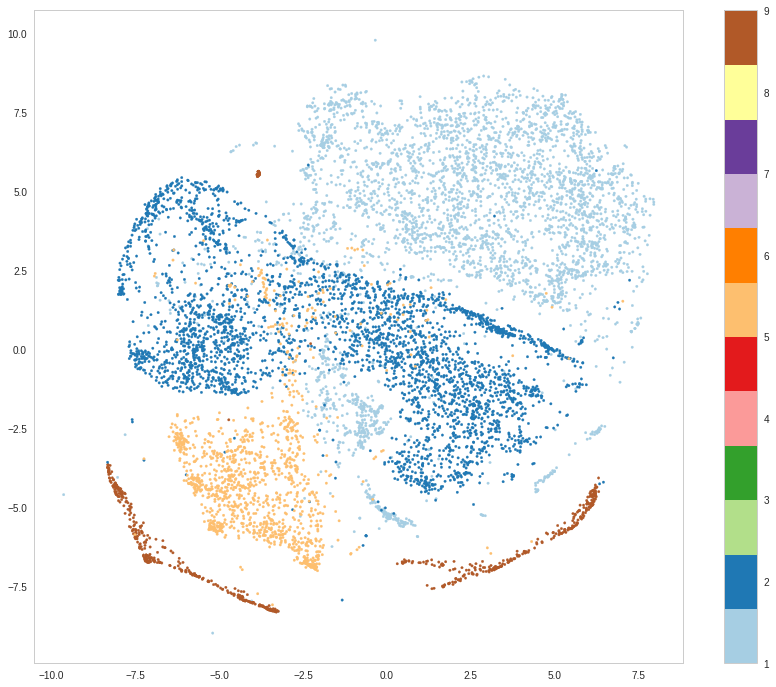

In [79]:
print(agc.shape)
print(agc[agc !=0].shape)
clist3 = clist*3
#cykm = [clist[z] for z in km[km !=4]]
#cya = [clist3[z] for z in agc
print(ceez[0][0])
print(cn.shape)
#from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(32,12))
# plt.subplot(121)
# plt.scatter(g_emb[:,0], g_emb[:,1], s=3, c=cykm)
cm = plt.cm.get_cmap('RdYlBu')
plt.subplot(122)

print(np.arange(0,1,len(g_emb)))
ax = plt.scatter(g_emb[:,0], g_emb[:,1], s=6, c=cn, cmap='Paired')
cbar = plt.colorbar()

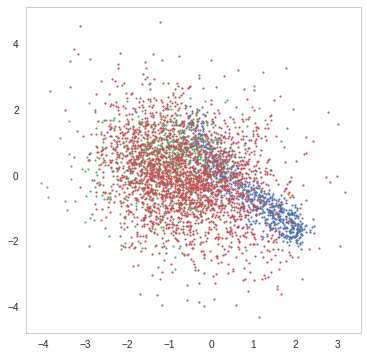

In [59]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111)
sc = ax.scatter(gfit[agc == 9][:,3], gfit[agc == 9][:,7], s=3)#, c=cn, cmap='Dark2')
sc = ax.scatter(gfit[agc == 10][:,3], gfit[agc == 10][:,7], s=3)#, c=cn, cmap='Dark2')
sc = ax.scatter(gfit[agc == 3][:,3], gfit[agc == 3][:,7], s=3)#, c=cn, cmap='Dark2')

(753, 128) (753, 64, 64, 1)
0 97
1 109
2 158
3 9
4 130
5 35
6 125
7 90


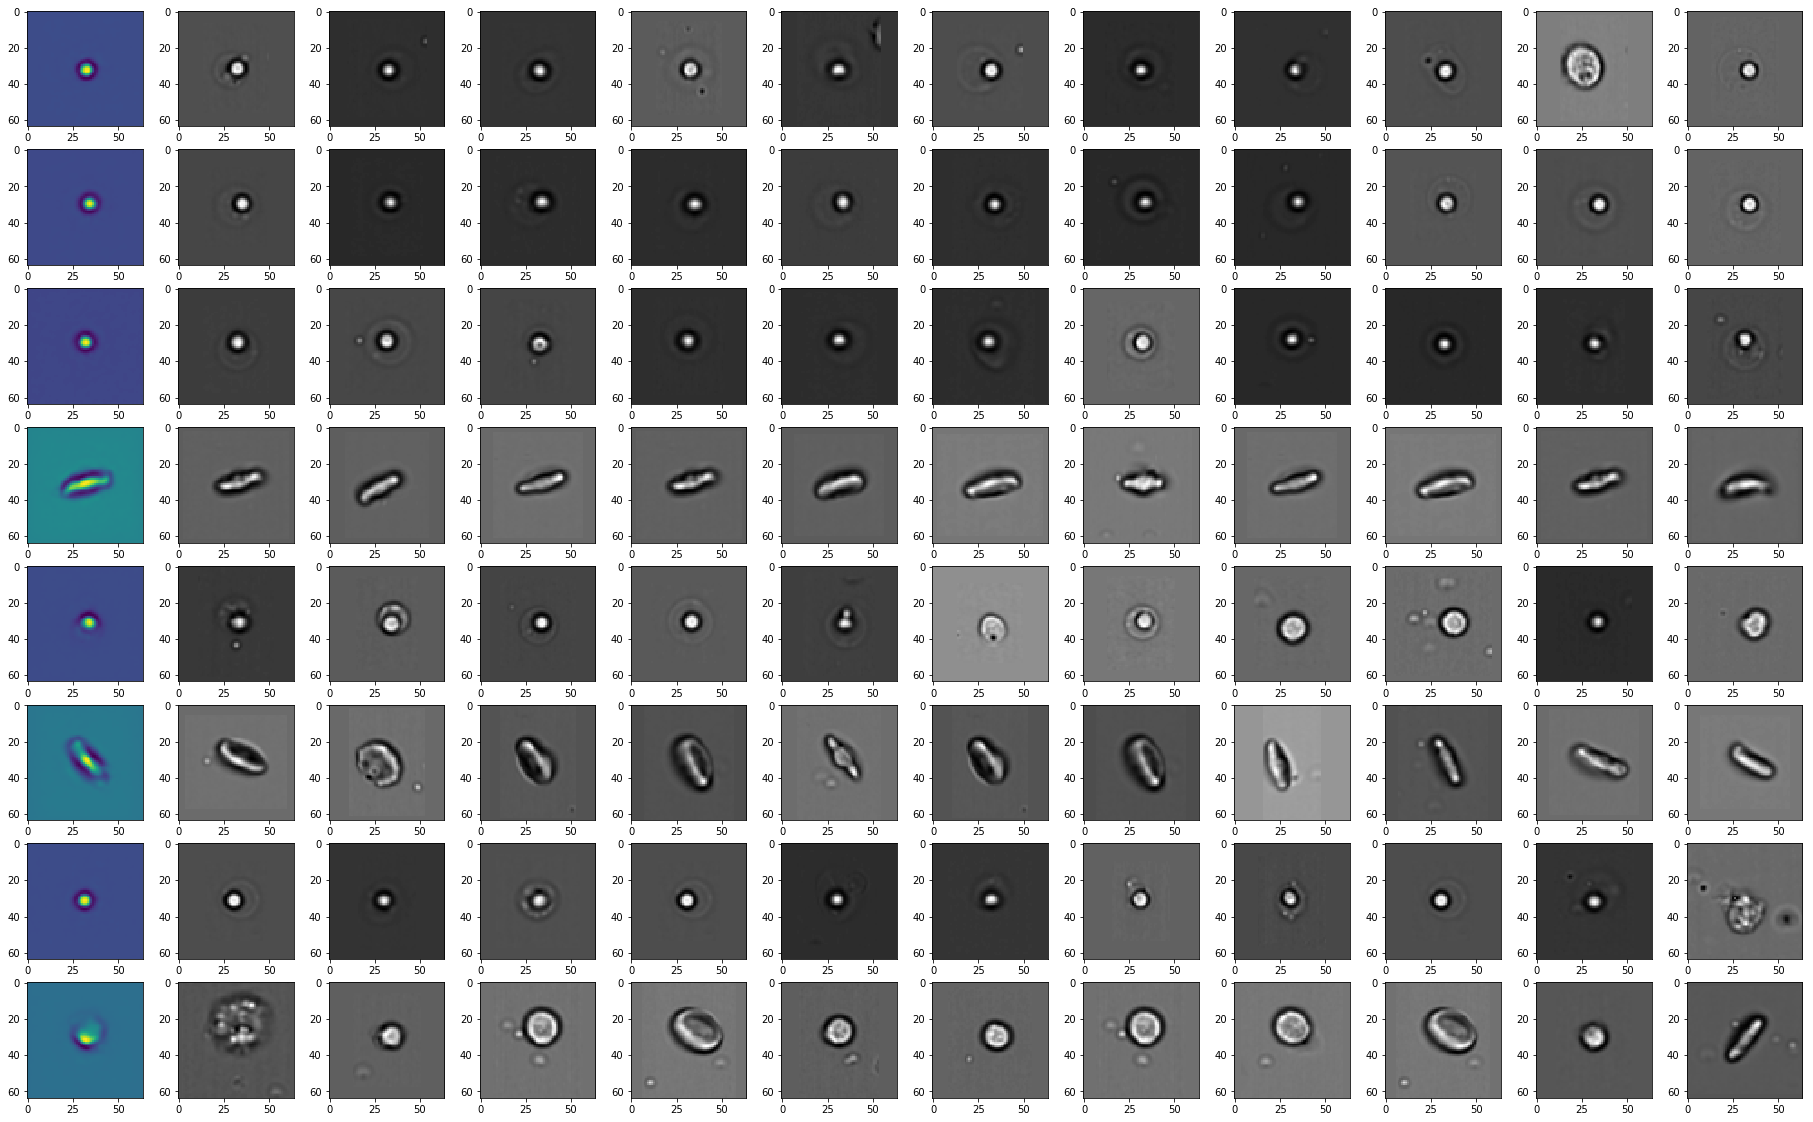

In [118]:
ain = 5
row4 = ximages[km == ain]
g4 = g_all[km == ain]
print(g4.shape, row4.shape)
agc4 = cluster.AgglomerativeClustering(n_clusters=8, affinity='euclidean', linkage="ward").fit_predict(g4)
agc4 = cluster.KMeans(n_clusters=8).fit_predict(g4)

nk = 8
plt.figure(figsize=(32, 2.5*nk))

counter = 1
shift = 0
for k in range(nk):
    row = row4[agc4 == k]
    print(k, row.shape[0])
    gk = g4[agc4 == k]
    gavk = np.mean(gk, axis=0)
    gavk = np.expand_dims(gavk.squeeze(), axis=0)
    resav = sess.run(sdd, feed_dict={enc:gavk})
    plt.subplot(nk, 12, counter)
    plt.imshow(resav.squeeze())
    counter += 1
    for i in range(11):
        plt.subplot(nk, 12, counter)
        counter += 1
        try:
            rnd = np.random.randint(0,len(row))
            plt.imshow(row[rnd,:,:,0], cmap='gray')
        except:
            plt.imshow(np.zeros((64,64)))

In [119]:
from sklearn.manifold import TSNE
g_emb4 = TSNE(n_components=2,perplexity=50, learning_rate=500).fit_transform(g4.astype(np.float64))



1 3661
9 721
2 3455
5 1254


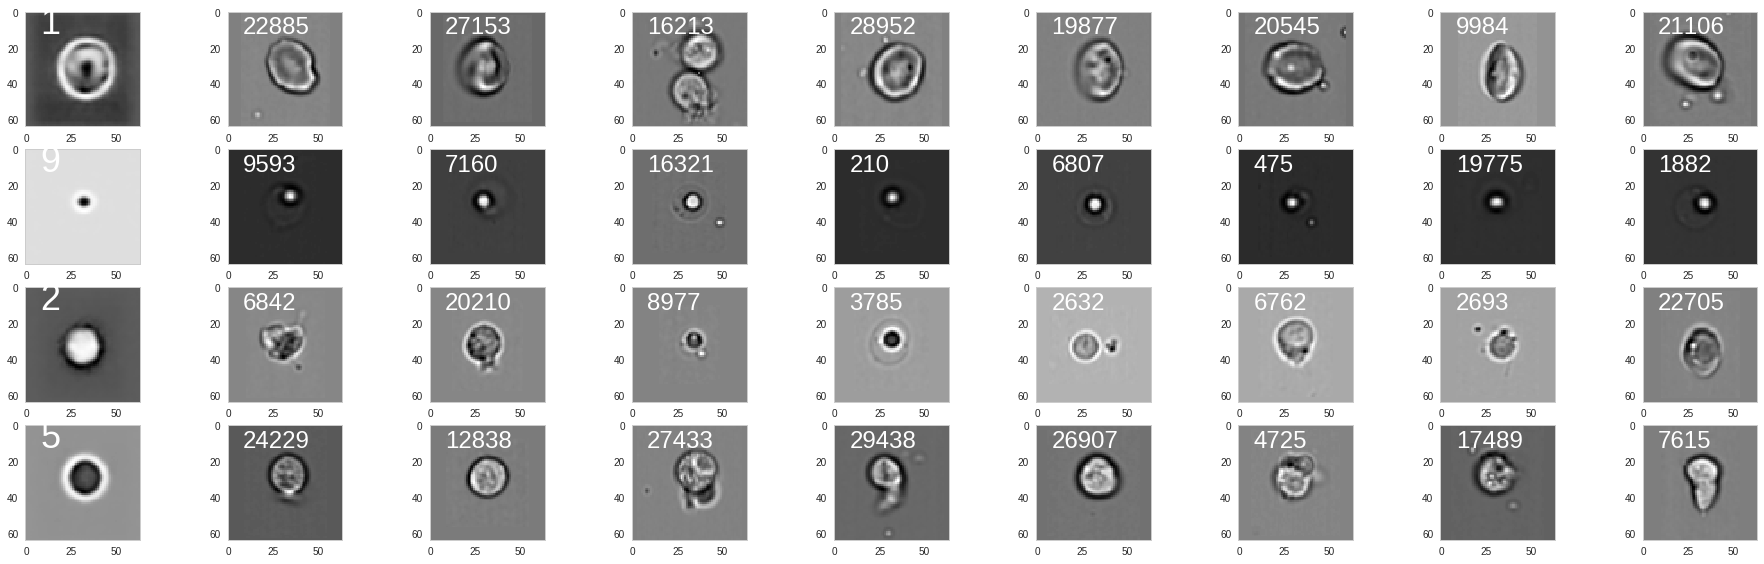

In [81]:
nk = nclust
plt.figure(figsize=(32, 2.5*nk))

counter = 1
shift = 0
for k in (1,9,2,5):
    #row = ximages[agc == k]
    rowdf = df[df['agc'] == k]
    inum = list(rowdf.index)
    print(k, len(rowdf))
    gk = g_all[agc == k]
    gavk = np.mean(gk, axis=0)
    gavk = np.expand_dims(gavk.squeeze(), axis=0)
    resav = sess.run(sdd, feed_dict={enc:gavk})
    plt.subplot(nk, 9, counter)
    plt.imshow(resav.squeeze())
    plt.text(8, 12,str(k), fontsize=36, color='white')
    counter += 1
    for i in range(8):
        plt.subplot(nk, 9, counter)
        counter += 1
        try:
            rnd = inum[np.random.randint(0,len(inum))]
            plt.imshow(ximages[rnd,:,:,0], cmap='gray')
            plt.text(8, 12,str(rnd), fontsize=24, color='white')
        except:
            plt.imshow(np.zeros((64,64)))


(1, 64, 64)
(1, 64, 64, 1)


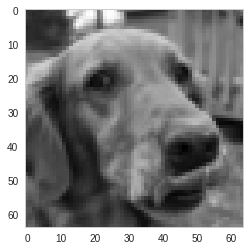

In [226]:
import skimage.io
daisyraw = skimage.io.imread("/home/cjw/disk2cjw/Data/daisy64.tif")

daisy = np.expand_dims(daisyraw, axis=0)
print(daisy.shape)
daisy = np.expand_dims(daisy, axis=-1)
mxd = np.amax(daisy)
mnd = np.amin(daisy)
daisy = (daisy - mnd)/(mxd - mnd)
daisy = daisy - np.mean(daisy) + 0.5
# daisy = np.expand_dims(daisy, axis=-1)
print(daisy.shape)
plt.imshow(daisy.squeeze(), cmap='gray')

In [227]:
de = sess.run(enc, feed_dict={images:daisy})
print(de.shape)
xr =0 + .1*np.random.randn(128)
xr[23:86] = 0
print(xr.shape)
de[0,:] = xr
dd  = sess.run(sdd, feed_dict={enc:de})

(1, 128)
(128,)


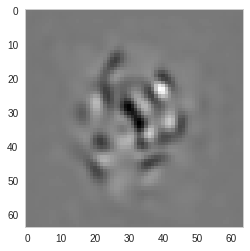

In [228]:
plt.imshow(dd.squeeze(), cmap='gray')


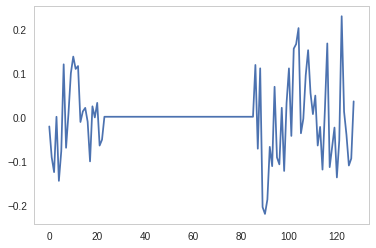

In [229]:
plt.plot(de.squeeze())